In [1]:
import sys
import numpy as np
import random
import pickle
import os
from PIL import Image
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import json
%matplotlib inline

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

In [3]:
def get_round_num(acc_hist, target_acc):
    if isinstance(acc_hist, list):
        acc_hist = np.array(acc_hist)
        
    # acc_hist should be np.ndarray or list here
    if acc_hist[-1] >= target_acc:
        round_num = np.argwhere(acc_hist>=target_acc)[0,0] + 1
    else:
        round_num = -1
    return round_num

def str2list(str):
    lis = str[1:-1].split(',')
    res = []
    for i, ele in enumerate(lis):
        if len(lis[i]) > 0:
            res.append(float(ele))
    
    return res

def result_file_parser(file_name):
    res = dict()
    with open(file_name) as f:
        for line in f.readlines():
            line = line.strip()
            if line[0]=='{':
                line = line.replace("\'", "\"")
                res['setting'] = json.loads(line)
            else:
                line = line.split(':')
                key_name, value_str = line[0], line[1]
                values = str2list(value_str)
                if len(values)>0:
                    res[key_name] = values
    return res

## FedAvg

In [53]:
# FedDyn-fedavg code
# 754 round when acc>0.814 in paper
feddyn_fedavg_acc = torch.load('./Output/feddyn-FedAvg_metrics.pkl')['tst_perf_sel_FedAvg'][:,1]


# FedLab-fedavg-scale
fedlab_fedavg_acc = result_file_parser(os.path.join('./Output/FedAvg/run1', 
                                                      'iid_Cifar10Net_cifar10.txt'))['acc']

## FedDyn

In [44]:
fedlab_feddyn_record = result_file_parser(os.path.join('./Output/FedDyn/run1', 'iid_Cifar10Net_cifar10.txt'))
fedlab_feddyn_acc = fedlab_feddyn_record['cld_mdl_test_acc']

feddyn_feddyn_record = torch.load('./Output/feddyn-FedDyn_metrics.pkl')
feddyn_feddyn_acc = feddyn_feddyn_record1['tst_perf_sel_FedDyn'][:,1]

total_round_num = len(fedlab_feddyn_acc)

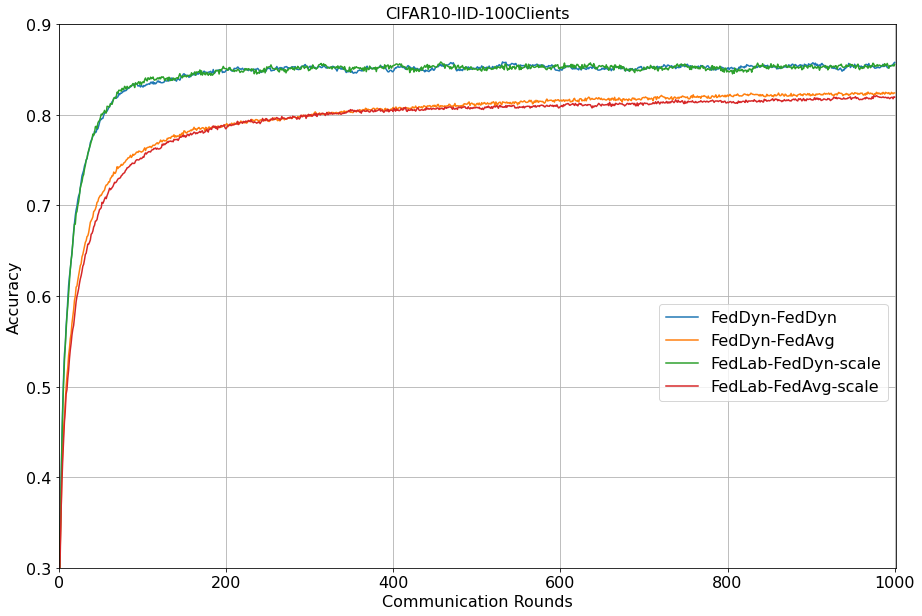

In [54]:
plt.figure(figsize=(15, 10))
plt.plot(np.arange(total_round_num)+1, feddyn_feddyn_acc, label='FedDyn-FedDyn')
plt.plot(np.arange(total_round_num)+1, feddyn_fedavg_acc, label='FedDyn-FedAvg')
plt.plot(np.arange(total_round_num)+1, fedlab_feddyn_acc, label='FedLab-FedDyn-scale')
plt.plot(np.arange(total_round_num)+1, fedlab_fedavg_acc, label='FedLab-FedAvg-scale')

plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Communication Rounds', fontsize=16)
plt.legend(fontsize=16, loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.xlim([0, total_round_num + 1])
plt.ylim([0.3, 0.9])
plt.title('CIFAR10-IID-100Clients', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(np.arange(0.3, 0.95, step=0.1),fontsize=16)
plt.grid(True)
# plt.savefig('./Output/CIFAR10_100_iid_plots.png', dpi=1000, bbox_inches='tight')
# plt.show() 

In [52]:
acc1 = 0.814
acc2 = 0.85
paper_feddyn_acc1_round = 67
paper_feddyn_acc2_round = 198
feddyn_feddyn_acc1_round = get_round_num(feddyn_feddyn_acc, acc1)
feddyn_feddyn_acc2_round = get_round_num(feddyn_feddyn_acc, acc2)
fedlab_feddyn_acc1_round = get_round_num(fedlab_feddyn_acc, acc1)
fedlab_feddyn_acc2_round = get_round_num(fedlab_feddyn_acc, acc2)

paper_fedavg_acc1_round = 754
feddyn_fedavg_acc1_round = get_round_num(feddyn_fedavg_acc, acc1)
fedlab_fedavg_acc1_round = get_round_num(fedlab_fedavg_acc, acc1)

print("                          FedDyn-Paper   FedDyn-official    FedDyn-FedLab")
print(f"Round for acc>{acc1*100:.2f}%: {paper_feddyn_acc1_round:15d},"
                                     f"{feddyn_feddyn_acc1_round:15d},"
                                     f"{fedlab_feddyn_acc1_round:15d},") 
print(f"Round for acc>{acc2*100:.2f}%: {paper_feddyn_acc2_round:15d},"
                                     f"{feddyn_feddyn_acc2_round:15d},"
                                     f"{fedlab_feddyn_acc2_round:15d},")
print("")

print("                          FedAvg-Paper   FedAvg-FedDyn    FedAvg-FedLab")
print(f"Round for acc>{acc1*100:.2f}%: {paper_fedavg_acc1_round:15d},"
                                     f"{feddyn_fedavg_acc1_round:15d},"
                                     f"{fedlab_fedavg_acc1_round:15d},") 

                          FedDyn-Paper   FedDyn-official    FedDyn-FedLab
Round for acc>81.40%:              67,             64,             65,
Round for acc>85.00%:             198,            185,            195,

                          FedAvg-Paper   FedAvg-FedDyn    FedAvg-FedLab
Round for acc>81.40%:             754,            491,            714,
